In [2]:
import geopandas as gpd
import contextily as cx
import pandas as pd
%matplotlib inline
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import scipy as sp
import xarray as xr
from sklearn.linear_model import LinearRegression

In [3]:
#datapath = '/Users/zhu/Dropbox/Code/Publications/ZEV-adoption-analysis-data/'
datapath = '{path to ZEV-adoption-analysis-data folder}'
filenames = ['wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.csv','wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_4km.csv']



In [4]:
voc_species = pd.DataFrame(columns = ['col'])

spc = ['CH$_4$', 'ch4','Gas_CH4_Insitu_S_AVMR','CH4_ppb','CH4_NOAA_Picarro_ppb_1min']
voc_species.loc[0,'col'] = spc

spc = ['Methanol', 'moh','x33_0334892273_CH5O_','CH3OH_NOAAPTR_ppbv','CH3OH_NOAAPTR_ppbv_all']
voc_species.loc[1,'col'] = spc

spc = ['Ethanol', 'eoh', 'x47_0491409302_C2H7O_', 'C2H5OH_NOAAPTR_ppbv', 'C2H5OH_NOAAPTR_ppbv_all']
voc_species.loc[2,'col'] = spc

spc = ['Acetaldehyde', 'acd','x45_0334892273_C2H5O_','CH3CHO_NOAAPTR_ppbv','CH3CHO_NOAAPTR_ppbv_all']
voc_species.loc[3,'col'] = spc

spc = ['Acetone', 'act','x59_0491409302_C3H7O_','AcetonePropanal_NOAAPTR_ppbv','AcetonePropanal_NOAAPTR_ppbv_all']
voc_species.loc[4,'col'] = spc

spc = ['Isoprene','iso','x69_0698776245_C5H9_','isoprene_NOAAPTR_ppbv','isoprene_NOAAPTR_ppbv_all']
voc_species.loc[5,'col'] = spc

spc = ['MACR+MVK','C4H6O_model','x71_0491409302_C4H7O_','MVKMAC_NOAAPTR_ppbv','MVKMAC_NOAAPTR_ppbv_all']
voc_species.loc[6,'col'] = spc

spc = ['Monoterpene','Monoterpenes_model','x137_1324768066_C10H17_','monoterpenes_NOAAPTR_ppbv','monoterpenes_NOAAPTR_ppbv_all']
voc_species.loc[7,'col'] = spc

spc = ['Benzene','ben','x79_0542297363_C6H7_','Benzene_NOAAPTR_ppbv','Benzene_NOAAPTR_ppbv_all']
voc_species.loc[8,'col'] = spc

spc = ['Toluene','tol','x93_0698776245_C7H9_','toluene_NOAAPTR_ppbv','toluene_NOAAPTR_ppbv_all']
voc_species.loc[9,'col'] = spc

spc = ['Benzaldehyde','bald','x107_0491409302_C7H7O_','benzaldehyde_NOAAPTR_ppbv','benzaldehyde_NOAAPTR_ppbv_all']
voc_species.loc[10,'col'] = spc

spc = ['Xylene','xyl','x107_0855255127_C8H11_','C8Aromatics_NOAAPTR_ppbv','C8Aromatics_NOAAPTR_ppbv_all']
voc_species.loc[11,'col'] = spc

spc = ['D5-siloxane', 'd5silx', 'x371_1012268066_C10H31O5Si5_', 'D5siloxane_NOAAPTR_ppbv', 'D5siloxane_NOAAPTR_ppbv_all']
voc_species.loc[12,'col'] = spc

spc = ['PCBTF', 'pcbtf','x181_0026397705_C7H4ClF3H_','PCBTF_NOAAPTR_ppbv','PCBTF_NOAAPTR_ppbv_all']
voc_species.loc[13,'col'] = spc

spc = ['Nonanal','nald','x143_1430358887_C9H19O_','nonanal_NOAAPTR_ppbv','nonanal_NOAAPTR_ppbv_all']
voc_species.loc[14,'col'] = spc

spc = ['Octanal','oald','x129_1273956299_C8H17O_','octanal_NOAAPTR_ppbv','octanal_NOAAPTR_ppbv_all']
voc_species.loc[15,'col'] = spc


In [5]:
wrf_comb_species = pd.DataFrame(columns = ['col'])
wrf_comb_species.loc['C4H6O_model','col'] = ['macr','mvk']
wrf_comb_species.loc['Monoterpenes_model','col'] = ['api','lim','eclp']

pair_wrf = []
for i in range(voc_species.shape[0]):
    if '_model' in voc_species.loc[i,'col'][1]:
        pair_wrf = pair_wrf + wrf_comb_species.loc[voc_species.loc[i,'col'][1],'col']
    else:
        pair_wrf.append(voc_species.loc[i,'col'][1])
        
pair_obs = []
for i in range(voc_species.shape[0]):
    pair_obs.append(voc_species.loc[i,'col'][2:])
pair_obs = np.array(pair_obs)

pair_model = []
for i in range(voc_species.shape[0]):
    pair_model.append(voc_species.loc[i,'col'][0])


In [7]:
def read_modeled_vocr(df_wrf_supp, this_df):
    cols = df_wrf_supp.columns
    vocr_cols = [col for col in cols if '_' not in col and col != 'co']
    df_wrf_vocr = df_wrf_supp.loc[:, vocr_cols]
    
    this_df.loc[:,'tot_vocr_model'] = df_wrf_vocr.sum(axis=1)
    this_df.loc[:,'calibrated_vocr_model'] = df_wrf_vocr.loc[:,pair_wrf].sum(axis=1)
    this_df.loc[:,'calibrated_ratio'] = this_df.loc[:,'calibrated_vocr_model']/this_df.loc[:,'tot_vocr_model']
    df_wrf_vocr = df_wrf_vocr.loc[:,pair_wrf] 
    return this_df

def read_vocr(df_wrf_supp, this_df, i_name):
    model_vocr=[col+'_model_vocr' for col in pair_model]
    obs_vocr=[col+'_obs_vocr' for col in pair_model]
    
    df_vocr = pd.DataFrame(columns=model_vocr+obs_vocr)
    
    for i_voc, this_voc in enumerate(pair_model):
        this_obs = voc_species.loc[i_voc,'col'][i_name+2]
        this_wrfs = []
        this_wrf = voc_species.loc[i_voc,'col'][1]
        if '_model' in this_wrf:
            this_wrfs = wrf_comb_species.loc[voc_species.loc[i_voc,'col'][1],'col']
        else:
            this_wrfs.append(this_wrf)
        this_wrf_conc_sum = this_df.loc[:,this_wrfs].sum(axis=1)
        for i_wrf, this_wrf in enumerate(this_wrfs):
            this_conc = this_df.loc[:,this_wrf]
            this_conc_ratio = this_df.loc[:,this_wrf]/this_wrf_conc_sum
            this_koh = df_wrf_supp.loc[:,this_wrf+'_rate']
            this_obs_conc = this_df.loc[:,this_obs]
            
            if i_wrf == 0:
                df_vocr.loc[:,this_voc+'_model_vocr'] = this_conc *1e-9 *2e19 * this_koh 
                df_vocr.loc[:,this_voc+'_obs_vocr'] = this_obs_conc *1e-9 *2e19 * this_koh * this_conc_ratio
            else:
                df_vocr.loc[:,this_voc+'_model_vocr'] = df_vocr.loc[:,this_voc+'_model_vocr']+this_conc *1e-9 *2e19 * this_koh 
                df_vocr.loc[:,this_voc+'_obs_vocr'] = df_vocr.loc[:,this_voc+'_obs_vocr'] + this_obs_conc *1e-9 *2e19 * this_koh * this_conc_ratio
                
            #print(this_voc)
            #print(np.nanmedian(df_vocr.loc[:,this_voc+'_obs_vocr'] ))
    return df_vocr
    
df_wrfs = []
df_vocrs = []
names = ['airborne_','mobile_','ground_']
for filename in filenames:
    print(filename)
    for i_name, name in enumerate(names):

        #read obs+model
        this_df = pd.read_csv(datapath + name + filename)

        # read vocr file
        df_wrf_supp = pd.read_csv(datapath + name + filename[:-4]+'-vocr.csv')

        #convert the unit of CH4 in airborne and ground
        if name in ['airborne_','ground_']:
            this_df.loc[:,'ch4'] = this_df.loc[:,'ch4']*1e3
            df_wrf_supp.loc[:,'ch4'] = df_wrf_supp.loc[:,'ch4']*1e3
        if name in ['ground_']:
            this_df.loc[:,'CH4'] = this_df.loc[:,'CH4']*1e3
        if name in ['airborne_']:
            this_df.loc[:,'Gas_CH4_Insitu_S_AVMR'] = this_df.loc[:,'Gas_CH4_Insitu_S_AVMR']*1e3
        if name in ['mobile_']:
            this_df.loc[:,'mek'] = this_df.loc[:,'mek']/1e3
            df_wrf_supp.loc[:,'mek'] = df_wrf_supp.loc[:,'mek']/1e3

        #read model VOCr
        this_df= read_modeled_vocr(df_wrf_supp, this_df)

        # read measured + modeled VOCr
        df_vocr = read_vocr(df_wrf_supp, this_df, i_name)
        model_vocr=[col+'_model_vocr' for col in pair_model]
        obs_vocr=[col+'_obs_vocr' for col in pair_model]

        this_df.loc[:,'calibrated_vocr_obs'] = df_vocr.loc[:,obs_vocr].sum(axis=1)
        this_df.loc[:,'calibrated_vocr_model'] = df_vocr.loc[:,model_vocr].sum(axis=1)
        df_wrfs.append(this_df)
        df_vocrs.append(df_vocr)
#correct octanal from the airborne measurements
df_wrfs[0]['x129_1273956299_C8H17O_'] = df_wrfs[0]['x129_1273956299_C8H17O_']*6.75
df_wrfs[3]['x129_1273956299_C8H17O_'] = df_wrfs[3]['x129_1273956299_C8H17O_']*6.75
    

wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.csv
wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_4km.csv


In [9]:
temp_bin = pd.read_csv(datapath+'temp_bin.csv')
print(temp_bin.columns)

Index(['Unnamed: 0', 'time_local', 'date', 'TEMP', 'temp_index',
       'temp_bin_index'],
      dtype='object')


In [10]:
#airborne
df_wrfs[0] = df_wrfs[0].drop(columns=['temp_bin_index']).merge(temp_bin,left_on='date_local',right_on='date')
#mobile
df_wrfs[1] = df_wrfs[1].drop(columns=['temp_bin_index']).merge(temp_bin,on='date')
#ground
df_wrfs[2] = df_wrfs[2].drop(columns=['temp_bin_index']).merge(temp_bin,on='date')
#airborne
df_wrfs[3] = df_wrfs[3].drop(columns=['temp_bin_index']).merge(temp_bin,left_on='date_local',right_on='date')
#mobile
df_wrfs[4] = df_wrfs[4].drop(columns=['temp_bin_index']).merge(temp_bin,on='date')
#ground
df_wrfs[5] = df_wrfs[5].drop(columns=['temp_bin_index']).merge(temp_bin,on='date')

In [11]:
def concatenate_df(pair_model, pair_wrf, airborne_obs, mobile_obs, ground_obs):
    conc_df = pd.DataFrame()

    #combine airborne
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[0].loc[:,airborne_obs].values
    this_df.loc[:,'temp_obs'] = df_wrfs[0].loc[:,'temp_obs'].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[0].loc[:,'temp_bin_index'].values
    this_df.loc[:,'data_index'] = 'RECAP Obs'
    this_df.loc[:,'area'] = df_wrfs[0].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = df_wrfs[0].loc[:,'cls_indxs'].values
    #this_df.loc[:,'ozone_bias'] = filter_df.loc[:,'ozone_bias'].values
    conc_df = pd.concat([conc_df, this_df])


    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[0].loc[:,pair_wrf].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[0].loc[:,'temperature_k_x'].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[0].loc[:,'temp_bin_index'].values
    this_df.loc[:,'data_index'] = 'RECAP wrf no cooking'
    this_df.loc[:,'area'] = df_wrfs[0].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = df_wrfs[0].loc[:,'cls_indxs'].values
    #this_df.loc[:,'ozone_bias'] = filter_df.loc[:,'ozone_bias'].values
    conc_df = pd.concat([conc_df, this_df])
    
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[3].loc[:,pair_wrf].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[3].loc[:,'temperature_k_x'].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[3].loc[:,'temp_bin_index'].values
    this_df.loc[:,'data_index'] = 'RECAP wrf with cooking'
    this_df.loc[:,'area'] = df_wrfs[3].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = df_wrfs[3].loc[:,'cls_indxs'].values
    #this_df.loc[:,'ozone_bias'] = filter_df.loc[:,'ozone_bias'].values
    conc_df = pd.concat([conc_df, this_df])
    
    if (pair_wrf not in ['NOx_model','co']):
        #combine mobile

        this_df = pd.DataFrame()

        this_df.loc[:,pair_model] = df_wrfs[1].loc[:,mobile_obs].values
        this_df.loc[:,'temp_obs'] = df_wrfs[1].loc[:,'AirTemp_C'].values + 273
        this_df.loc[:,'temp_wrf'] = df_wrfs[1].loc[:,'temperature_k_x'].values
        this_df.loc[:,'temp_bin_index'] = df_wrfs[1].loc[:,'temp_bin_index'].values
        this_df.loc[:,'data_index'] = 'SUNVEX Obs'
        this_df.loc[:,'area'] = df_wrfs[1].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = df_wrfs[1].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])


        this_df = pd.DataFrame()
        this_df.loc[:,pair_model] = df_wrfs[1].loc[:,pair_wrf].values
        this_df.loc[:,'data_index'] = 'SUNVEX wrf no cooking'
        this_df.loc[:,'temp_obs'] = df_wrfs[1].loc[:,'AirTemp_C'].values + 273
        this_df.loc[:,'temp_bin_index'] = df_wrfs[1].loc[:,'temp_bin_index'].values
        this_df.loc[:,'temp_wrf'] = df_wrfs[1].loc[:,'temperature_k_x'].values
        this_df.loc[:,'area'] = df_wrfs[1].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = df_wrfs[1].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])
        
        this_df = pd.DataFrame()
        this_df.loc[:,pair_model] = df_wrfs[4].loc[:,pair_wrf].values
        this_df.loc[:,'data_index'] = 'SUNVEX wrf with cooking'
        this_df.loc[:,'temp_obs'] = df_wrfs[4].loc[:,'AirTemp_C'].values + 273
        this_df.loc[:,'temp_bin_index'] = df_wrfs[4].loc[:,'temp_bin_index'].values
        this_df.loc[:,'temp_wrf'] = df_wrfs[4].loc[:,'temperature_k_x'].values
        this_df.loc[:,'area'] = df_wrfs[4].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = df_wrfs[4].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])
    
    #combine ground
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,ground_obs].values
    this_df.loc[:,'data_index'] = 'SUNVEX Obs'
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    this_df.loc[:,'area'] = 'Pasadena'
    this_df.loc[:,'cls_indxs'] = 4.5
    conc_df = pd.concat([conc_df, this_df])
   
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,pair_wrf].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    this_df.loc[:,'data_index'] = 'SUNVEX wrf no cooking'
    this_df.loc[:,'area'] = 'Pasadena'
    this_df.loc[:,'cls_indxs'] = 4.5
    conc_df = pd.concat([conc_df, this_df])
    
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[5].loc[:,pair_wrf].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[5].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[5].loc[:,'temperature_k_x'].values
    this_df.loc[:,'data_index'] = 'SUNVEX wrf with cooking'
    this_df.loc[:,'area'] = 'Pasadena'
    this_df.loc[:,'cls_indxs'] = 4.5
    conc_df = pd.concat([conc_df, this_df])
    return conc_df


In [14]:
model_vocr=[col+'_model_vocr' for col in pair_model]
obs_vocr=[col+'_obs_vocr' for col in pair_model]

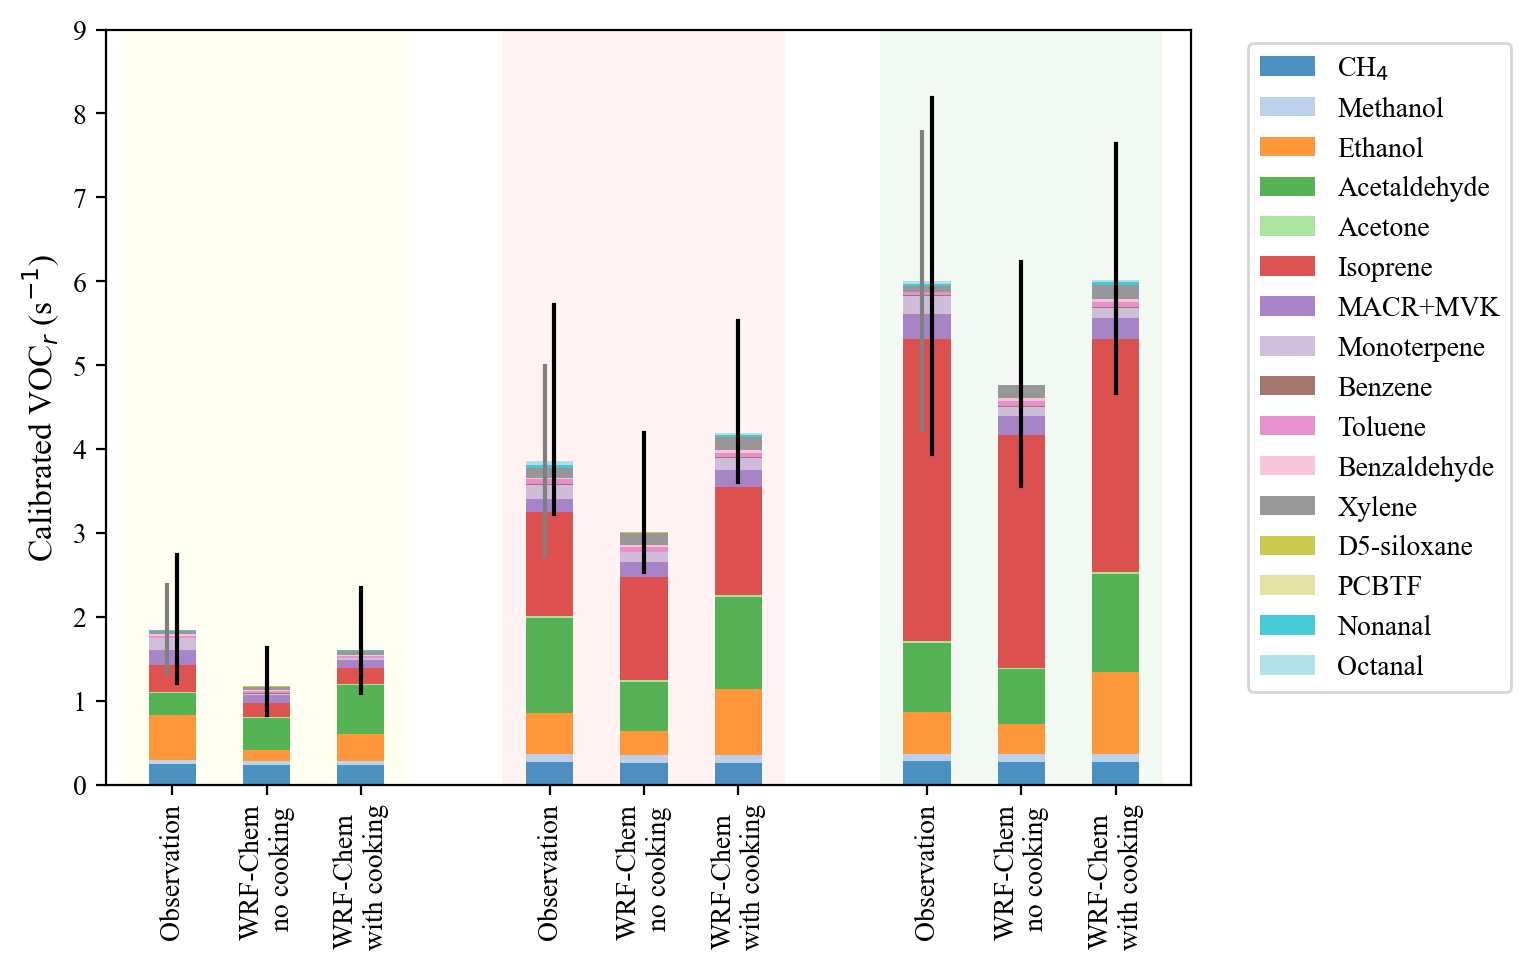

In [19]:
#add 25-75
names = ['RECAP','SUNVEX Mobile','SUNVEX Ground']
ymaxs= [2,4,10]
concat_mean_df = pd.DataFrame()
concat_std_df = []
concat_25_df = []
concat_75_df = []
obs_labels = [-2,2,5]
wrf_labels = [-1,3,6]


for i in range(3):
    this_wrf = pd.DataFrame()
    for i_var, this_var in enumerate(pair_model):
        this_wrf.loc[obs_labels[i],this_var] = np.nanmedian(df_vocrs[i].loc[:,this_var+'_obs_vocr'])
        this_wrf.loc[wrf_labels[i],this_var] = np.nanmedian(df_vocrs[i].loc[:,this_var+'_model_vocr'])
        this_wrf.loc[wrf_labels[i]+1,this_var] = np.nanmedian(df_vocrs[i+3].loc[:,this_var+'_model_vocr'])
        this_wrf.loc[wrf_labels[i]+2,this_var] =np.nan
    concat_mean_df = pd.concat([concat_mean_df,this_wrf])
    concat_std_df.append(np.nanstd(df_vocrs[i].loc[:,obs_vocr].dropna().sum(axis=1)))
    concat_std_df.append(np.nanstd(df_vocrs[i].loc[:,model_vocr].dropna().sum(axis=1)))
    concat_std_df.append(np.nanstd(df_vocrs[i+3].loc[:,model_vocr].dropna().sum(axis=1)))
    
    concat_25_df.append(np.nanquantile(df_vocrs[i].loc[:,obs_vocr].dropna().sum(axis=1),0.25))
    concat_25_df.append(np.nanquantile(df_vocrs[i].loc[:,model_vocr].dropna().sum(axis=1),0.25))
    concat_25_df.append(np.nanquantile(df_vocrs[i+3].loc[:,model_vocr].dropna().sum(axis=1),0.25))
    
    concat_75_df.append(np.nanquantile(df_vocrs[i].loc[:,obs_vocr].dropna().sum(axis=1),0.75))
    concat_75_df.append(np.nanquantile(df_vocrs[i].loc[:,model_vocr].dropna().sum(axis=1),0.75))
    concat_75_df.append(np.nanquantile(df_vocrs[i+3].loc[:,model_vocr].dropna().sum(axis=1),0.75))

mean_df = concat_mean_df.sum(axis=1)
fig, axs = plt.subplots(1,1,figsize=(7,5),dpi=200)
plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["font.family"] = "Arial"
plt.fill_between([-0.5,2.5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='yellow',edgecolor='None',alpha=0.05)
plt.fill_between([3.5,6.5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='red',edgecolor='None',alpha=0.05)
    
plt.fill_between([7.5,10.5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='green',edgecolor='None',alpha=0.05)
    
concat_mean_df.plot(kind='bar', stacked=True,ax=axs, edgecolor='none',colormap='tab20',alpha=0.8, rot=0)

xlist = np.array([-2+2.05,-1+2,0+2,2+2.05,3+2,4+2,6+2.05,7+2,8+2])
for i in range(len(xlist)):
    plt.plot([xlist[i],xlist[i]],[concat_25_df[i],concat_75_df[i]],color='k')

#plt.errorbar(np.array([-2,-1,0,2,3,4,6,7,8])+2, mean_df[mean_df>0].values, yerr=concat_std_df, fmt='.',color='k')

plt.errorbar(np.array([-2,2,6])+1.95, mean_df[mean_df>0].values[[0,3,6]], yerr=mean_df[mean_df>0].values[[0,3,6]]*0.3, fmt='none',color='gray')

axs.set_xticks(np.array([-2,-1,0,2,3,4,6,7,8])+2, ['Observation','WRF-Chem\n no cooking','WRF-Chem\n with cooking']*3, fontsize=10,rotation=90)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(loc="upper center", ncol=4,mode = "expand",bbox_to_anchor=(0.5, 1.5))
plt.xlim([-0.7,10.8])
plt.ylim([0,9])
#plt.yscale("log")  
plt.ylabel('Calibrated VOC$_r$ (s$^{-1}$)',fontsize=12)
plt.rcParams["font.family"] = "Times New Roman"


In [20]:
#new PAN simulation
#use the new pan dataset
#read pblh file
#pblh_df = pd.DataFrame()
import os
import icartt
import glob
from datetime import datetime
datapath = datapath + 'SunVEX-PAN-R1/'
datapath_full = [x[0] for x in os.walk(datapath)]
pan_df = pd.DataFrame()
filenames = glob.glob(datapath_full[0]+'/*.ict')

for filename in filenames:
    ict = icartt.Dataset(filename)
    this_df = pd.DataFrame()
    this_df.loc[:,'midtime_UTC'] = ict.data['midtime_UTC']
    this_df.loc[:,'starttime_UTC'] = ict.data['starttime_UTC'] 
    this_df.loc[:,'stoptime_UTC'] = ict.data['stoptime_UTC']
    this_df.loc[:,'PAN_NOAACIMS'] = ict.data['PAN_NOAACIMS']
    
    this_year = filename.split('_')[-2][2:4]
    this_month = filename.split('_')[-2][4:6]
    this_day = filename.split('_')[-2][6:8]
    n = ict.data['midtime_UTC'].shape[0]
    this_hour = [0]*n
    this_min = [0]*n
    this_sec = [0]*n
    pan_time = []
    for i in range(n):
        this_hour[i] = int(ict.data['midtime_UTC'][i]/3600)
        this_min[i] = int((ict.data['midtime_UTC'][i] - 3600*this_hour[i])/60)
        this_sec[i] = int(ict.data['midtime_UTC'][i] - 3600*this_hour[i] - 60*this_min[i])
        datetime_str = '{}/{}/{} {:02d}:{:02d}:{:02d}'.format(this_month, this_day,this_year,this_hour[i],this_min[i],this_sec[i])
        pan_time.append(datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S'))

    this_df.loc[:,'PAN_time'] = pan_time
    pan_df = pd.concat([pan_df, this_df])
pan_df = pan_df.sort_values(by='PAN_time').set_index('PAN_time').resample('1min').mean().reset_index().rename(columns={'PAN_NOAACIMS':'PAN_NOAACIMS_v1'})
pan_df['PAN_NOAACIMS_v1'] = pan_df['PAN_NOAACIMS_v1']/1e3
for i in [2,5]:
    df_wrfs[i]['time_obs'] = pd.to_datetime(df_wrfs[i]['time_obs'])
    df_wrfs[i] = df_wrfs[i].merge(pan_df,right_on='PAN_time',left_on='time_obs')
    

In [25]:
#ground measurements only
def concatenate_ground_df(pair_obs, pair_wrf, pair_model):
    conc_df = pd.DataFrame()
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,pair_obs].values
    this_df.loc[:,'tag'] = 'Observation'
    this_df.loc[:,'data_index'] = 0
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    conc_df = pd.concat([conc_df, this_df])

    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,pair_wrf].values
    this_df.loc[:,'tag'] = 'WRF-Chem no cooking'
    this_df.loc[:,'data_index'] = 2
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    conc_df = pd.concat([conc_df, this_df])
    
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[5].loc[:,pair_wrf].values
    this_df.loc[:,'tag'] = 'WRF-Chem with cooking'
    this_df.loc[:,'data_index'] = 4
    this_df.loc[:,'temp_bin_index'] = df_wrfs[5].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[5].loc[:,'temperature_k_x'].values
    conc_df = pd.concat([conc_df, this_df])
    return conc_df

species = pd.DataFrame(columns = ['col'])


spc = ['PAN (ppb)','PAN_NOAACIMS_v1','pan']
species.loc[0,'col'] = spc


In [28]:
i=0

pair_obs = species.loc[i,'col'][1]
pair_wrf = species.loc[i,'col'][2]
pair_model = species.loc[i,'col'][0]
conc_df = concatenate_ground_df(pair_obs, pair_wrf, pair_model)


this_wrf = pd.DataFrame()

this_wrf.loc[0,pair_model] = np.nanmedian(df_wrfs[2].loc[:,pair_obs])
this_wrf.loc[1,pair_model] = np.nanmedian(df_wrfs[2].loc[:,pair_wrf])
this_wrf.loc[2,pair_model] = np.nanmedian(df_wrfs[5].loc[:,pair_wrf])

this_wrf_25 = pd.DataFrame()

this_wrf_25.loc[0,pair_model] = np.nanquantile(df_wrfs[2].loc[:,pair_obs],0.25)
this_wrf_25.loc[1,pair_model] = np.nanquantile(df_wrfs[2].loc[:,pair_wrf],0.25)
this_wrf_25.loc[2,pair_model] = np.nanquantile(df_wrfs[5].loc[:,pair_wrf],0.25)

this_wrf_75 = pd.DataFrame()

this_wrf_75.loc[0,pair_model] = np.nanquantile(df_wrfs[2].loc[:,pair_obs],0.75)
this_wrf_75.loc[1,pair_model] = np.nanquantile(df_wrfs[2].loc[:,pair_wrf],0.75)
this_wrf_75.loc[2,pair_model] = np.nanquantile(df_wrfs[5].loc[:,pair_wrf],0.75)

    

(0.0, 1.4)

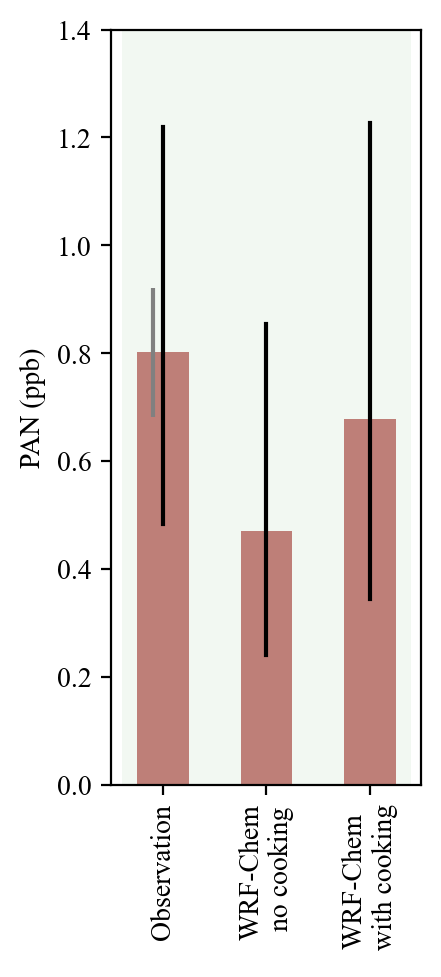

In [29]:
fig, axs = plt.subplots(1,1,figsize=(2,5),dpi=200)
bplot = this_wrf.plot(kind='bar',ax=axs, edgecolor='none',color='brown',alpha=0.6, rot=0,width=0.5)
bplot.get_legend().remove()
#xlist = np.array([-2+2.05,-1+2,0+2,2+2.05,3+2,4+2,6+2.05,7+2,8+2])
#for i in range(len(xlist)):
#    plt.plot([xlist[i],xlist[i]],[concat_25_df[i],concat_75_df[i]],color='k')
for i in [0,1,2]:
    plt.plot([i,i],[this_wrf_25.loc[i,'PAN (ppb)'],this_wrf_75.loc[i,'PAN (ppb)']],color='k')
axs.set_ylabel('PAN (ppb)')
axs.set_xticks(np.array([0,1,2]), ['Observation','WRF-Chem\n no cooking','WRF-Chem\n with cooking'], fontsize=10,rotation=90)
plt.errorbar(np.array([0-0.1]), this_wrf.loc[0,'PAN (ppb)'], yerr=this_wrf.loc[0,'PAN (ppb)']*0.15, fmt='none',color='gray')
plt.fill_between([-0.4,2.4],[-0.01,-0.01],[1.4,1.4], facecolor='green',edgecolor='None',alpha=0.05)
plt.ylim([0,1.4])